# 복잡한 object 구별하기 (강이지 vs 고양이) : from Deep learning with Python 

## 아래 코드는 "케라스 창시자에게 배우는 딥러닝"의  역자 Github (https://github.com/rickiepark/deep-learning-with-python-notebooks) 에서 받은 소스파일을 교육목적으로 재구성함

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # The kernel appears to have died. It will restart automatically 문제 수정

## 데이터 처리를 위해 scipy 를 설치

In [9]:
!pip install scipy

import keras
keras.__version__

import os, shutil # 파일 연산을 위한 라이브러리 

## 파이썬 기능을 사용하여, 파일 분류 
이 주피터 노트북이 있는 폴더에 데이터 zip 을 압축 해제 하기 바랍니다.

In [12]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로 
original_dataset_dir = 'C:/Users/Owner/Desktop/희철/datasets/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = 'C:/Users/Owner/Desktop/희철/datasets/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [13]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


## 데이터 전처리 

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1.	사진 파일을 읽습니다.
2.	JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3.	그다음 부동 소수 타입의 텐서로 변환합니다.
4.	픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).

좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다. 케라스는 `keras.preprocessing.image`에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다. 특히 `ImageDataGenerator` 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다 (강아지 vs 고양이)
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [16]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
# history= model.fit(train_images,train_labels,epochs=20, batch_size=100, verbose=2,validation_data=(test_images, test_labels))

history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)


Epoch 1/30
100/100 [==============================] - 25s 252ms/step - loss: 0.6908 - accuracy: 0.5160 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/30
100/100 [==============================] - 25s 249ms/step - loss: 0.6798 - accuracy: 0.5505 - val_loss: 0.6751 - val_accuracy: 0.5370
Epoch 3/30
100/100 [==============================] - 25s 245ms/step - loss: 0.6733 - accuracy: 0.5655 - val_loss: 0.6679 - val_accuracy: 0.6500
Epoch 4/30
100/100 [==============================] - 25s 245ms/step - loss: 0.6489 - accuracy: 0.6270 - val_loss: 0.6599 - val_accuracy: 0.5890
Epoch 5/30
100/100 [==============================] - 24s 241ms/step - loss: 0.6031 - accuracy: 0.6665 - val_loss: 0.6614 - val_accuracy: 0.5860
Epoch 6/30
100/100 [==============================] - 25s 245ms/step - loss: 0.5730 - accuracy: 0.6955 - val_loss: 0.6117 - val_accuracy: 0.6780
Epoch 7/30
100/100 [==============================] - 25s 250ms/step - loss: 0.5121 - accuracy: 0.7345 - val_loss: 0.5710 - val_ac

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

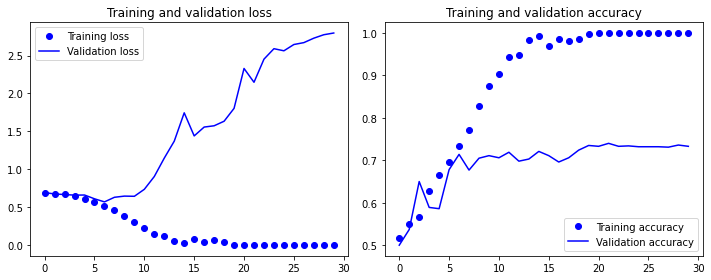

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Question: 

현재 테스트에서 overfitting이 일어나고 있습니다.
수업 시간에 배웠던 다양한 방법을 통해 overfitting을 최소화 시키고, 결과를 위와 같이 그래프로 표시하세요. 
결과값이 나타낸 대로 저장을 하여 제출하시기 바랍니다.  